In [1]:
# Same as Version three except using connectionID instead of nodeID (which changes)
# Added community detection features - label prop and louvain
# Added triangles and clustering coefficient

In [2]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
graph = Graph("bolt://localhost", auth=("neo4j", "123"))
import pickle

In [3]:
#Function to down sample negative examples
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [4]:
def create_LP_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.adamicAdar(
               p1, p2, {relationshipQuery: $relType}) AS aa,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn,
           algo.linkprediction.resourceAllocation(
               p1, p2, {relationshipQuery: $relType}) AS ra
               
    """
    print ("pairs")
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    print ("features")
   
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    print ("merge") 
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def create_community_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minT,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxT,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minC,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxC
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    print (features.count())
    print (features.tail())
    return pd.merge(data, features, on = ["node1", "node2"])

def communitydetection_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS lp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS lv
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

In [5]:
# Create the classifier
        
#rfclassifier = RandomForestClassifier(n_estimators=500, max_depth=50, 
                                  # random_state=0,class_weight="balanced")

rfclassifier = ExtraTreesClassifier(n_estimators=1000, max_depth=50, 
                                  random_state=0,class_weight="balanced")

# Feature column names for a full set of features
#columns = [
#    "cn","aa", "pa", "tn","ra", # graph features
#    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
#    "sp", "sl" # community detection features
#]

# Feature column names for a full link prediction features
columns = ["cn","aa","pa", "tn","ra", # link prediction features
    "lp","lv",                        # Community detection features
    "minT", "maxT", "minC", "maxC"    # triangle features       
]

In [6]:
# TRAINING
# Find positive links -Training data
train_positive_links = graph.run("""
MATCH (p1:Person)-[:SUB_GRAPH_TRAINING]->(p2:Person)
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 1 AS label
""").to_data_frame()

In [7]:
# TEST
# Find positive links - Test data
test_positive_links = graph.run("""
MATCH (p1:Person)-[:SUB_GRAPH_TEST]->(p2:Person)
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 1 AS label
""").to_data_frame()

In [8]:
#train_positive_links.tail()

In [9]:
# TRAINING
# Find negative links - Training data
train_negative_links = graph.run("""
MATCH (p1:Person)
WHERE (p1)-[:SUB_GRAPH_TRAINING]-()
MATCH (p1)-[:SUB_GRAPH_TRAINING*2..3]-(p2)
WHERE not((p1)-[:SUB_GRAPH_TRAINING]-(p2))
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 0 AS label
""").to_data_frame()

In [10]:
#train_negative_links.tail()

In [11]:
# TEST
# Find negative examples - test set
test_negative_links = graph.run("""
MATCH (p1:Person)
WHERE (p1)-[:SUB_GRAPH_TEST]-()
MATCH (p1)-[:SUB_GRAPH_TEST*2..3]-(p2)
WHERE not((p1)-[:SUB_GRAPH_TEST]-(p2))
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 0 AS label
""").to_data_frame()

In [12]:
# TRAINING
# Remove duplicates - training set
train_negative_links = train_negative_links.drop_duplicates()

#Down sample Negative links
training_df = train_negative_links.append(train_positive_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [13]:
#train_negative_links.count()

In [14]:
# TEST
# Remove duplicates - test set
test_negative_links = test_negative_links.drop_duplicates()

# Create DataFrame from positive and negative examples
test_df = test_negative_links.append(test_positive_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
# Down sample negative examples
test_df = down_sample(test_df)

In [15]:
# TRAINING
# Apply the link prediction features to the data set
training_df = create_LP_features(training_df, "SUB_GRAPH_TRAINING")

pairs
features
merge


In [16]:
#training_df.count()

In [17]:
# TEST
# Apply the link prediction features to the data set
test_df = create_LP_features(test_df, "SUB_GRAPH_TEST")

pairs
features
merge


In [18]:
# TRAINING
# Community detection - label propogation
graph.run("""
CALL algo.labelPropagation("Person", "SUB_GRAPH_TRAINING", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,didConverge,p1,p5,...,p50,p75,p90,p95,p99,p100,weightProperty,write,partitionProperty,writeProperty
0,155,41,27,359,81835,36950,1,False,1,1,...,2,3,4,5,9,32,weight,True,partitionTrain,partitionTrain


In [19]:
# TEST
# Community detection - label propogation
graph.run("""
CALL algo.labelPropagation("Person", "SUB_GRAPH_TEST", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,didConverge,p1,p5,...,p50,p75,p90,p95,p99,p100,weightProperty,write,partitionProperty,writeProperty
0,92,11,14,213,81835,72297,1,False,1,1,...,1,1,1,2,5,20,weight,True,partitionTest,partitionTest


In [20]:
# TRAINING
# Community detection - Louvain
graph.run("""
CALL algo.louvain.stream("Person", "SUB_GRAPH_TRAINING", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

{'constraints_added': 0,
 'constraints_removed': 0,
 'indexes_added': 0,
 'indexes_removed': 0,
 'labels_added': 0,
 'labels_removed': 0,
 'nodes_created': 0,
 'nodes_deleted': 0,
 'properties_set': 81835,
 'relationships_deleted': 0,
 'relationships_created': 0,
 'contains_updates': True}

In [21]:
# TEST
# Community detection - Louvain
graph.run("""
CALL algo.louvain.stream("Person", "SUB_GRAPH_TEST", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

{'constraints_added': 0,
 'constraints_removed': 0,
 'indexes_added': 0,
 'indexes_removed': 0,
 'labels_added': 0,
 'labels_removed': 0,
 'nodes_created': 0,
 'nodes_deleted': 0,
 'properties_set': 81835,
 'relationships_deleted': 0,
 'relationships_created': 0,
 'contains_updates': True}

In [22]:
# Use the community detection algorithm to find the label prop and louvain features seeded into the graph
# TRAINING
training_df = communitydetection_features(training_df, "partitionTrain", "louvainTrain")
#TEST
test_df = communitydetection_features(test_df, "partitionTest", "louvainTest")

In [23]:
#training_df.count()

In [24]:
graph.run("""
CALL algo.triangleCount('Person', 'SUB_GRAPH_TRAINING', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,65,37,4,439,81835,47967,0.261,0,0,0,0,0,1,5,10,23,171,True,trianglesTrain,coefficientTrain


In [25]:
graph.run("""
CALL algo.triangleCount('Person', 'SUB_GRAPH_TEST', { write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,32,10,2,457,81835,13611,0.088,0,0,0,0,0,0,0,3,11,69,True,trianglesTest,coefficientTest


In [26]:
training_df = create_community_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = create_community_features(test_df, "trianglesTest", "coefficientTest")

node1    163788
node2    163788
minT     163788
maxT     163788
minC     163788
maxC     163788
dtype: int64
        node1  node2  minT  maxT  minC  maxC
163783  35002  35630    14    14 0.933 0.933
163784  76213  20755     0    10 0.000 0.222
163785  74411  11952     0     0 0.000 0.000
163786  79740  40402     2     7 0.090 0.333
163787  81475  47573     1     5 0.139 1.000
node1    38246
node2    38246
minT     38246
maxT     38246
minC     38246
maxC     38246
dtype: int64
       node1  node2  minT  maxT  minC  maxC
38241   1123  34016     0     0 0.000 0.000
38242  45041  45041    15    15 1.000 1.000
38243  40858  67429     1     1 0.167 1.000
38244  77013   3571     1     2 0.667 1.000
38245  41263  46290     3     3 1.000 1.000


In [27]:
#training_df.to_csv('d:/projectdata/ModelOutput/all_links.csv')

In [28]:
#training_df.tail()

,Measure,Score
0,Accuracy,0.972
1,Precision,0.959
2,Recall,0.985


'Feature Importance'

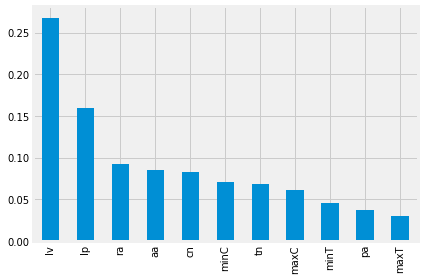

In [29]:
# Run the classifier againt the training data
X = training_df[columns]
y = training_df["label"]
rfclassifier.fit(X, y)

# Apply the test data and evaluate performance
predictions = rfclassifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, rfclassifier)

In [30]:
filename = 'd:\projectdata\models\CDMLWU_LP5.sav'
pickle.dump(rfclassifier, open(filename, 'wb'))